# Chat With Tools

In [1]:
import torch
import uuid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel, LoraConfig

from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings, ChatHuggingFace
from langchain.tools import tool

from langchain.schema import AIMessage, HumanMessage
from langchain_core.messages import SystemMessage, AnyMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableConfig, Runnable
from langchain_core.tools import BaseTool
from langchain_core.utils.function_calling import convert_to_openai_tool

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated, Any, Dict, Optional, TypedDict, Union, List
from lightning import Fabric

from IPython.display import display, Markdown, Image, SVG
from os import walk

### Set mixed precision

In [2]:
torch.set_float32_matmul_precision("medium")
fabric = Fabric(accelerator="cuda", devices=1, precision="bf16-mixed")
device = fabric.device
fabric.launch()

Using bfloat16 Automatic Mixed Precision (AMP)


## RAG

### Load Embedding Data

In [3]:
embed_model_name = "sentence-transformers/all-mpnet-base-v2"

embeddings = HuggingFaceEmbeddings(model_name=embed_model_name)

### Load vector store

In [4]:
vector_store = FAISS.load_local(
    "./faiss_dnd_index",
    embeddings=embeddings,
    allow_dangerous_deserialization=True
)
retriever = vector_store.as_retriever()

### Mock data

In [5]:
n_users = 10

data = {
    "user_id": [f"user_{i+1}" for i in range(n_users)],
    "name": [f"User{i+1}" for i in range(n_users)],
    "age": np.random.randint(18, 60, size=n_users),
    "email": [f"user{i+1}@example.com" for i in range(n_users)],
    "num_posts": np.random.randint(0, 500, size=n_users),
    "num_likes": np.random.randint(0, 10000, size=n_users),
    "num_followers": np.random.randint(0, 100000, size=n_users),
    "num_following": np.random.randint(0, 5000, size=n_users),
}

df = pd.DataFrame(data)
display(df)

,user_id,name,age,email,num_posts,num_likes,num_followers,num_following
0,user_1,User1,30,user1@example.com,311,7777,37874,202
1,user_2,User2,57,user2@example.com,380,4590,56551,3237
2,user_3,User3,57,user3@example.com,46,8255,1651,2249
3,user_4,User4,50,user4@example.com,122,3045,57246,3679
4,user_5,User5,25,user5@example.com,421,1078,85481,3883
5,user_6,User6,32,user6@example.com,470,7942,97368,2791
6,user_7,User7,47,user7@example.com,455,96,17072,1573
7,user_8,User8,48,user8@example.com,2,5761,41789,3019
8,user_9,User9,18,user9@example.com,228,1958,33844,4538
9,user_10,User10,53,user10@example.com,155,9690,23873,3086


## Functions

In [6]:
@tool
def spell_retrieve(query: str) -> str:
    """Retrieve information about dungeons and dragons spell.
    
    Args:
        query (str): The spell name to search for.

    Returns:
        str: The spell information.
    """
    retrieved_docs = vector_store.similarity_search(query, k=3)

    contents = "\n\n".join(
        (f"{doc.page_content}")
        for doc in retrieved_docs
    )
    
    return contents

@tool
def user(name: str) -> str:
    """
    User infomation retreiver

    Args:
        name (str): The name of user.

    Returns:
        str: The user information.
    """
    return f'{df[df['name'] == name]}.'

tools = [
    spell_retrieve,
    user
]

## Workflow

```
[User Message] 
     ↓
[xLAM-2] → [Check if Tool Call is Required] 
     ├── No → [Return to Llama 3 with "No tool needed"]
     └── Yes → [Detect Tool to Call] → [Prepare Structured Tool Call] → [Execute Tool] → [Send Result to Llama 3]
                          ↓
               [Llama 3] → [Generate Final Natural Reply]
     ↓
[Final reply to User]
```

## Custom Sate

In [7]:
class State(TypedDict):
    name: str
    stat: str
    messages: Annotated[list[AnyMessage], add_messages]
    context: str

## Tool Calling Class

In [8]:
class ToolCallRequest(TypedDict):
    """A typed dict that shows the inputs into the invoke_tool function."""

    name: str
    arguments: Dict[str, Any]

In [9]:
class ToolCalling():
    def __init__(self, model_name: str, tools: list[BaseTool]):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cpu")
        self.pipe = pipeline(
            task="text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            return_full_text=False,
            max_new_tokens=512,
            top_k=10,
            device_map="auto"
        )
        self._llm = HuggingFacePipeline(pipeline=self.pipe)
        self.chat = ChatHuggingFace(llm=self._llm, tokenizer=self.tokenizer)
        self.rendered_tools = [convert_to_openai_tool(f) for f in tools]

    def invoke_tool(
            self,
            tool_call_request: Union[ToolCallRequest, List[ToolCallRequest]], 
            config: Optional[RunnableConfig] = None
    ):
        """A function that we can use the perform a tool invocation.

        Args:
            tool_call_request: a dict that contains the keys name and arguments.
                The name must match the name of a tool that exists.
                The arguments are the arguments to that tool.
            config: This is configuration information that LangChain uses that contains
                things like callbacks, metadata, etc.See LCEL documentation about RunnableConfig.

        Returns:
            output from the requested tool
        """

        print("Tool call request:", tool_call_request)
        
        # Sometimes the model outputs a list of tool call requests, 
        # so I loop each tool call and append to list
        
        if isinstance(tool_call_request, list):
            output = list()

            for tool_call in tool_call_request:
                tool_name_to_tool = {tool.name: tool for tool in tools}
                name = tool_call["name"]
                requested_tool = tool_name_to_tool[name]
                output.append(requested_tool.invoke(tool_call["arguments"], config=config))
            return output
        
        tool_name_to_tool = {tool.name: tool for tool in tools}
        name = tool_call_request["name"]
        requested_tool = tool_name_to_tool[name]
        return requested_tool.invoke(tool_call_request["arguments"], config=config)
    
    def invoke(self, state: State) -> List[str]:
        system_prompt = SystemMessage(f"""\
        You are an assistant that has access to the following set of tools. 
        Here are the names and descriptions for each tool:

        {self.rendered_tools}

        Given the user input, return the name and input of the tool to use. 
        Return your response as a JSON blob with 'name' and 'arguments' keys.

        The `arguments` should be a dictionary, with keys corresponding 
        to the argument names and the values corresponding to the requested values.
        """)

        chain = self.chat | JsonOutputParser() | self.invoke_tool
        messages = [system_prompt] + [state['messages'][-1]]

        try:
            response = chain.invoke(messages)
        except Exception as e:
            print("Error invoking tool:", e)
            response = ["No tool needed"]

        if not response:
            response = ["No tool needed"]
        
        return {"context": AIMessage(response)}

### ToolCalling Class Usage

In [10]:
tool_calling_model_name = "Salesforce/Llama-xLAM-2-8b-fc-r"

tool_calling = ToolCalling(
    model_name=tool_calling_model_name,
    tools=tools
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cpu


In [11]:
def tool(state: State) -> str:
    return tool_calling.invoke(state)

graph = StateGraph(State)
graph.add_edge(START, "tool call")
graph.add_node("tool call", tool)
graph.add_edge("tool call", END)

graph = graph.compile()

In [12]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj"],
    lora_dropout=0.2,
    bias="none",
    task_type="CAUSAL_LM"
)

## Llama-3 Chat Class

In [13]:
class LlamaChat():
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, load_in_4bit=True)
        self.adapter_model_name = './weights/bestRL_SFT'
        self.model = PeftModel.from_pretrained(self.model, self.adapter_model_name)
        self.model = self.model.merge_and_unload()
        self.pipe = pipeline(
            task="text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            return_full_text=False,
            max_new_tokens=2048,
            top_k=10,
            device_map="auto"
        )
        self._llm = HuggingFacePipeline(pipeline=self.pipe)
        self.chat = ChatHuggingFace(llm=self._llm, tokenizer=self.tokenizer)

    def generate(self, state: State) -> Dict[str, Any]:
        system_message_content = (
            "<|begin_of_text|>\n"
            "<|start_header_id|>system<|end_header_id|>\n"
            "You are a highly skilled Dungeon Master (DM) for Dungeons & Dragons 5th Edition. "
            "Your job is to read the player’s input and reply with an immersive, clear, and engaging narration that advances the story and game mechanics.\n"
            "\n"
            # "Advice for the DM:\n"
            # "  - Describe scenes with vivid sensory details and atmosphere.\n"
            # "  - Offer meaningful choices if players ask for choices; respect player agency and avoid railroading.\n"
            # "  - Keep secret die rolls hidden; reveal only the results and their effects.\n"
            # "  - Use rules faithfully but prioritize fun and pacing over strict book-keeping.\n"
            # "  - Improvise when players surprise you, but maintain internal consistency.\n"
            # "  - Avoid technical jargon in your narration—stay in character and tone.\n"
            # "\n"
            "Basic D&D 5e Rules Summary:\n"
            "  - Initiative: roll a d20 + Dexterity modifier to determine turn order.\n"
            "  - Actions: on your turn you can take one Action, one Bonus Action (if available), and move up to your speed.\n"
            "  - Reactions: special actions triggered outside your turn, such as Opportunity Attacks.\n"
            "  - Advantage & Disadvantage: roll two d20s; take the higher roll for advantage or the lower for disadvantage.\n"
            "  - Spellcasting: consumes spell slots; cantrips are cast at will; concentration holds one spell at a time.\n\n"
            "Campaign detail:\n"
            "At the heart of Barovia, a land shrouded in perpetual mist and the oppressive gloom of Castle Ravenloft looming above, the adventurers find themselves trapped within the cursed domain of Strahd.\n"
            "The infamous vampire lord Strahd von Zarovich rules with iron and blood, his tragic past entwined with dark magic and unrequited love.\n"
            "The party’s destiny is guided by a cryptic Tarokka deck reading from Madam Eva, randomizing the locations of three powerful artifacts—the Sunsword, the Tome of Strahd, and the Holy Symbol of Ravenkind—to set the stakes for their final confrontation.\n"
            "Early survival often hinges on navigating the deathly Svalich Woods, where sentient trees and wendigos prowl, and entering the perilous Death House to learn that not all horrors are undead.\n"
            "In the Village of Barovia, the PCs meet Ismark and Ireena Kolyana—siblings haunted by Strahd’s obsession—and may face a night assault in the graveyard by the vampire himself.\n"
            "As they pursue their quest, they reach Vallaki’s forced festivals of joy, unmasking Baron Vallakovich’s dark secrets beneath the town’s brittle gaiety. :\n"
            "The modular nature of the land allows for side trips to Argynvostholt’s haunted halls, Van Richten’s Tower of mad experimentation, and the haunted Ruins of Berez—each offering unique encounters like the Abbot’s twisted deva or Baba Lysaga’s creeping hut. :\n"
            "A crucial detour to the Wizard of Wines winery leads through Yester Hill, where twig blights and corrupted druids guard a dark gem needed to lift the vineyard’s curse. :\n"
            "At their journey’s culmination, the PCs storm Castle Ravenloft’s shadowed halls, confront Strahd amid gothic spires, and challenge his vampire spawn and brides in a climactic battle for Barovia’s freedom. :\n"
            "The module’s gothic ambiance is enriched by haunting music cues, Tarokka card handouts, and richly illustrated maps that deepen immersion in Barovia’s despair. :\n"
            "This is the retrieved context:\n\n"
            f"{state['context']}\n\n"
            "You must follow the these rules strictly\n\n "
            "1. DO NOT simulate the result of player\'s actions.\n\n"
            "2.Do not include <CHARACTER>.\n\n"
            "3.Use the context provided.\n\n"
            "YOU MUST ALSO USE these current game state data :"
            "Current location: Vallaki’s forced festivals of joy"
            # "When you answer the player, you must respond in proper markdown format: heading, table, bold, italic, paragraph, blockquotes.\n"
        )

        print('State:', state)
        print('Context:', state["context"])
        print('Generating response ...')

        conversation_messages = [
            message
            for message in state["messages"]
            if message.type in ("human", "system")
            or (message.type == "ai" and not message.tool_calls)
        ]

        prompt = [SystemMessage(system_message_content)] + conversation_messages

        response = self.chat.invoke(prompt)
        
        return {"messages": [response]}

### LlamaChat Class Usage

In [14]:
llama_model_name = "meta-llama/Llama-3.1-8B-Instruct"

llama = LlamaChat(model_name=llama_model_name)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/yuaylong/miniconda3/envs/nlp/lib/python3.12/site-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_magnitude_vector.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_magnitude_vector.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_magnitude_vector.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_B

In [15]:
# text = "<|start_header_id|>player_1<|end_header_id|>\nCan I cast meteor swarm?<|eot_id|>"

# input_state = {
#     "name": "player_1",
#     "messages": [
#         HumanMessage(content=text)
#     ],
#     "context": ""
# }

# response = llama.generate(state=input_state)
# print(response)

## LangGraph Demo

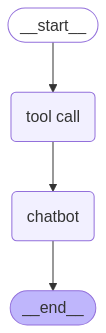

In [16]:
def tool(state: State):
    return tool_calling.invoke(state)

def chatbot(state: State) -> str:
    return llama.generate(state=state)

memory = MemorySaver()

graph = StateGraph(State)

graph.add_edge(START, "tool call")
graph.add_node("tool call", tool)

graph.add_edge("tool call", "chatbot")

graph.add_node("chatbot", chatbot)
graph.add_edge("chatbot", END)

graph = graph.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [17]:
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": "123"}}

text = "<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=text)
    ],
    "context": ""
}

# for step in graph.stream(
#     input_state,
#     config=config,
#     stream_mode="values",
# ):
#     step["messages"][-1].pretty_print()

response = graph.invoke(input_state, config)

print(response['messages'][-1].content)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'spell_retrieve', 'arguments': {'query': 'meteor swarm'}}]
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='489af465-4af6-4d01-8ce1-3ea2deac2dfe')], 'context': AIMessage(content=["# Meteor Swarm\n## Spell Name\nMeteor Swarm  \n![](https://static.wikia.nocookie.net/dnd-5e/images/9/99/Meteor.png/revision/latest/scale-to-width-down/225?cb=20221130233621)\n![](https://static.wikia.nocookie.net/dnd-5e/images/9/99/Meteor.png/revision/latest/scale-to-width-down/225?cb=20221130233621)  \nFrom Player's Handbook, page 259.\n## Description\n*9th-level evocation*\n* **Casting Time:** 1 action\n* **Range:** 1 mile\n* **Components:** V, S\n* **Duration:** Instantaneous\n- **Casting Time:** 1 action\n\n**At Higher Levels:** When you cast this spell using a spell slot of 4th level or higher, the num

In [18]:
text = "<|start_header_id|>player_3<|end_header_id|>\nCan you give me infomation of name User3?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=text)
    ],
    "context": ""
}

# for step in graph.stream(
#     input_state,
#     config=config,
#     stream_mode="values",
# ):
#     step["messages"][-1].pretty_print()


response = graph.invoke(input_state, config)

print(response['messages'][-1].content)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'user', 'arguments': {'name': 'User3'}}]
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='489af465-4af6-4d01-8ce1-3ea2deac2dfe'), AIMessage(content="You can cast Meteor Swarm, but be aware that as a level 1 wizard, you do not have access to the spell. Meteor Swarm is a 9th-level evocation spell, which means you are still far from being able to cast it.\n\nAs you browse through the dusty tomes in the Baron's library, you overhear whispers of a mysterious gathering in the town square. The townspeople seem to be preparing for the Vallaki's forced festivals of joy, but there's an undercurrent of unease in the air. The Baron's guards are on high alert, and the air is thick with the smell of roasting meats and freshly baked bread.\n\nYou notice a group of traveling performers, including a 

In [19]:
input_message = "<|start_header_id|>player1<|end_header_id|>\nMy name is Tsubasa.<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=input_message)
    ],
    "context": ""
}

# for step in graph.stream(
#     input_state,
#     config=config,
#     stream_mode="values",
# ):
#     step["messages"][-1].pretty_print()


response = graph.invoke(input_state, config)

print(response['messages'][-1].content)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'user', 'arguments': {'name': 'Tsubasa'}}]
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='489af465-4af6-4d01-8ce1-3ea2deac2dfe'), AIMessage(content="You can cast Meteor Swarm, but be aware that as a level 1 wizard, you do not have access to the spell. Meteor Swarm is a 9th-level evocation spell, which means you are still far from being able to cast it.\n\nAs you browse through the dusty tomes in the Baron's library, you overhear whispers of a mysterious gathering in the town square. The townspeople seem to be preparing for the Vallaki's forced festivals of joy, but there's an undercurrent of unease in the air. The Baron's guards are on high alert, and the air is thick with the smell of roasting meats and freshly baked bread.\n\nYou notice a group of traveling performers, including 

In [20]:
input_message = "<|start_header_id|>player1<|end_header_id|>\nhello, What is my name?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=input_message)
    ],
    "context": ""
}

# for step in graph.stream(
#     input_state,
#     config=config,
#     stream_mode="values",
# ):
#     step["messages"][-1].pretty_print()


response = graph.invoke(input_state, config)

print(response['messages'][-1].content)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'user', 'arguments': {'name': 'player1'}}]
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='489af465-4af6-4d01-8ce1-3ea2deac2dfe'), AIMessage(content="You can cast Meteor Swarm, but be aware that as a level 1 wizard, you do not have access to the spell. Meteor Swarm is a 9th-level evocation spell, which means you are still far from being able to cast it.\n\nAs you browse through the dusty tomes in the Baron's library, you overhear whispers of a mysterious gathering in the town square. The townspeople seem to be preparing for the Vallaki's forced festivals of joy, but there's an undercurrent of unease in the air. The Baron's guards are on high alert, and the air is thick with the smell of roasting meats and freshly baked bread.\n\nYou notice a group of traveling performers, including 

In [21]:
input_message = "<|start_header_id|>player1<|end_header_id|>\nhello, What is my name?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=input_message)
    ],
    "context": ""
}

# for step in graph.stream(
#     input_state,
#     config=config,
#     stream_mode="values",
# ):
#     step["messages"][-1].pretty_print()


response = graph.invoke(input_state, config)

print(response['messages'][-1].content)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'user', 'arguments': {'name': 'player1'}}]
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='489af465-4af6-4d01-8ce1-3ea2deac2dfe'), AIMessage(content="You can cast Meteor Swarm, but be aware that as a level 1 wizard, you do not have access to the spell. Meteor Swarm is a 9th-level evocation spell, which means you are still far from being able to cast it.\n\nAs you browse through the dusty tomes in the Baron's library, you overhear whispers of a mysterious gathering in the town square. The townspeople seem to be preparing for the Vallaki's forced festivals of joy, but there's an undercurrent of unease in the air. The Baron's guards are on high alert, and the air is thick with the smell of roasting meats and freshly baked bread.\n\nYou notice a group of traveling performers, including 